In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
!pip install yfinance
import yfinance as yf
import pandas as pd


In [3]:
import torch
from torch.utils.data import TensorDataset, DataLoader
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import matplotlib.pyplot as plt
import time

from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import MinMaxScaler


# Loading the Price Data

In [4]:
start_date ='2015-01-01'
end_date = '2019-12-31'
price = yf.download("BTC-USD", start=start_date, end=end_date)

#relative_price, will calculate the change in % compared to the day before.
relative_price = (price/price.shift(1)-1)

/tmp/ipython-input-2196474014.py:3: FutureWarning: YF.download() has changed argument auto_adjust default to True
  price = yf.download("BTC-USD", start=start_date, end=end_date)
[*********************100%***********************]  1 of 1 completed


In [5]:
price.head()

Price,Close,High,Low,Open,Volume
Ticker,BTC-USD,BTC-USD,BTC-USD,BTC-USD,BTC-USD
Date,,,,,
2015-01-01,314.248993,320.434998,314.002991,320.434998,8036550
2015-01-02,315.032013,315.838989,313.565002,314.079010,7860650
2015-01-03,281.082001,315.149994,281.082001,314.846008,33054400
2015-01-04,264.195007,287.230011,257.612000,281.145996,55629100
2015-01-05,274.473999,278.341003,265.084015,265.084015,43962800


In [6]:
relative_price.head()

Price,Close,High,Low,Open,Volume
Ticker,BTC-USD,BTC-USD,BTC-USD,BTC-USD,BTC-USD
Date,,,,,
2015-01-01,NaN,NaN,NaN,NaN,NaN
2015-01-02,0.002492,-0.014343,-0.001395,-0.019835,-0.021888
2015-01-03,-0.107767,-0.002181,-0.103593,0.002442,3.205047
2015-01-04,-0.060079,-0.088593,-0.083499,-0.107036,0.682956
2015-01-05,0.038907,-0.030947,0.029005,-0.057130,-0.209716


In [7]:
#add in the label
#I can start with the % change of the daily closing price, then create labels.
#another way could be to look at the next day High vs today Close.
price_2= price.Close
price['change']=price_2.apply(lambda x: x.shift(-1)/x -1)
price['change_label']=price['change'].apply (lambda x: x>0 )
#NaN > 0 gives false? Perhaps I could drop na before this step?


#copy the label to relative_price part as well.
relative_price['change'] = price['change']
relative_price['change_label']=price['change_label']

In [8]:
print (len(price),len(relative_price))

1825 1825


In [9]:
price = price.dropna()
relative_price = relative_price.dropna()

In [10]:
#price would lose the last day, because no information on next day price to create the label
#relative price, would ALSO lose the first day, because no information to calculate the relative changes .
print (len(price),len(relative_price))

1824 1823


In [11]:
relative_price[5:12]

Price,Close,High,Low,Open,Volume,change,change_label
Ticker,BTC-USD,BTC-USD,BTC-USD,BTC-USD,BTC-USD,,
Date,,,,,,,
2015-01-07,0.028471,0.038953,0.038075,0.041754,0.069738,-0.037331,False
2015-01-08,-0.037331,-0.015461,-0.003194,0.028167,-0.196419,0.024913,True
2015-01-09,0.024913,-0.010271,-0.005819,-0.039954,-0.063250,-0.053759,False
2015-01-10,-0.053759,-0.010261,-0.023409,0.017423,-0.184538,-0.033246,False
2015-01-11,-0.033246,-0.029463,-0.032584,-0.044187,0.192377,0.008040,True
2015-01-12,0.008040,-0.026588,0.000607,-0.030815,0.037334,-0.156593,False
2015-01-13,-0.156593,-0.014423,-0.170792,0.004689,2.858196,-0.211449,False


In [12]:
relative_price['change_label'].value_counts()

,count
change_label,
True,1000
False,823


# Adding in technical indicators

In [13]:
price.head()

Price,Close,High,Low,Open,Volume,change,change_label
Ticker,BTC-USD,BTC-USD,BTC-USD,BTC-USD,BTC-USD,,
Date,,,,,,,
2015-01-01,314.248993,320.434998,314.002991,320.434998,8036550,0.002492,True
2015-01-02,315.032013,315.838989,313.565002,314.079010,7860650,-0.107767,False
2015-01-03,281.082001,315.149994,281.082001,314.846008,33054400,-0.060079,False
2015-01-04,264.195007,287.230011,257.612000,281.145996,55629100,0.038907,True
2015-01-05,274.473999,278.341003,265.084015,265.084015,43962800,0.042682,True


In [14]:
def get_technical_indicators(dataset):
    # Create 7 and 21 days Moving Average
    dataset['ma7'] = dataset['Close'].rolling(window=7).mean()
    dataset['ma21'] = dataset['Close'].rolling(window=21).mean()

    # Create MACD
    #Moving Average Convergence Divergence

    #dataset['26ema'] = pd.ewma(dataset['Close'], span=26)
    dataset['26ema'] = dataset['Close'].ewm(span=26).mean()
    #dataset['12ema'] = pd.ewma(dataset['Close'], span=12)
    dataset['12ema'] = dataset['Close'].ewm(span=12).mean()
    dataset['MACD'] = (dataset['12ema']-dataset['26ema'])

    # Create Bollinger Bands
    #dataset['20sd'] = pd.stats.moments.rolling_std(dataset['Close'],20)
    dataset['20sd'] = dataset["Close"].rolling(window=20).std()
    dataset['upper_band'] = dataset['ma21'] + (dataset['20sd']*2)
    dataset['lower_band'] = dataset['ma21'] - (dataset['20sd']*2)

    # Create Exponential moving average
    dataset['ema'] = dataset['Close'].ewm(com=0.5).mean()

    # Create Momentum
    #dataset['momentum'] = dataset['Close']-1

    return dataset

In [15]:
test_df = pd.DataFrame({'B':[1,2,3,4,5,6,7]})

In [16]:
pd.__version__

'2.2.2'

In [17]:
price_processed = get_technical_indicators(price)
#price.head()

In [18]:
price_processed.tail()

Price,Close,High,Low,Open,Volume,change,change_label,ma7,ma21,26ema,12ema,MACD,20sd,upper_band,lower_band,ema
Ticker,BTC-USD,BTC-USD,BTC-USD,BTC-USD,BTC-USD,,,,,,,,,,,
Date,,,,,,,,,,,,,,,,
2019-12-25,7275.155762,7357.020020,7220.991211,7325.755859,21559505149,-0.004974,False,7296.817801,7272.840518,7368.426134,7267.012086,-101.414048,216.709771,7706.260059,6839.420977,7296.493060
2019-12-26,7238.966797,7388.302734,7200.386719,7274.799316,22787010034,0.007062,True,7301.978167,7262.871908,7358.836553,7262.697426,-96.139127,206.236480,7675.344867,6850.398948,7258.142218
2019-12-27,7290.088379,7363.529297,7189.934082,7238.141113,22777360996,0.003827,True,7312.159877,7250.638184,7353.744096,7266.911419,-86.832677,193.541738,7637.721659,6863.554708,7279.439659
2019-12-28,7317.990234,7399.041016,7286.905273,7289.031250,21365673026,0.014302,True,7330.278669,7239.293062,7351.095662,7274.769698,-76.325964,178.778125,7596.849312,6881.736812,7305.140042
2019-12-29,7422.652832,7513.948242,7279.865234,7317.647461,22445257702,-0.017468,False,7317.573521,7232.545805,7356.396193,7297.520949,-58.875243,179.979293,7592.504391,6872.587219,7383.481902


In [19]:
price_processed = price_processed.dropna()
price_processed.isnull().value_counts()

,,,,,,,,,,,,,,,,count
"(Close, BTC-USD)","(High, BTC-USD)","(Low, BTC-USD)","(Open, BTC-USD)","(Volume, BTC-USD)","(change, )","(change_label, )","(ma7, )","(ma21, )","(26ema, )","(12ema, )","(MACD, )","(20sd, )","(upper_band, )","(lower_band, )","(ema, )",
False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,1804


In [20]:
price_processed.head()
#although I'm not very sure about how 26ema can be calculated when I don't have 26 days of data before this day ?
#and ema, with this particular set up, seems a bit off? : https://stackoverflow.com/questions/37924377/does-pandas-calculate-ewm-wrong
#the link above provides an alternate view, but I think with the amount of days I have, it shouldn't really matter that much.
#Let's keep going w/o it first.

Price,Close,High,Low,Open,Volume,change,change_label,ma7,ma21,26ema,12ema,MACD,20sd,upper_band,lower_band,ema
Ticker,BTC-USD,BTC-USD,BTC-USD,BTC-USD,BTC-USD,,,,,,,,,,,
Date,,,,,,,,,,,,,,,,
2015-01-21,226.897003,227.787994,211.212006,211.378006,29924600,0.028687,True,211.516142,252.197332,237.296354,225.220423,-12.075931,39.542978,331.283287,173.111376,221.826443
2015-01-22,233.406006,237.018997,226.434006,227.322006,33544600,-0.002258,False,214.882143,248.347666,236.943225,226.512490,-10.430735,36.472461,321.292588,175.402743,229.546152
2015-01-23,232.878998,234.845001,225.195999,233.516998,24621700,0.064274,True,218.422429,244.435617,236.580372,227.513418,-9.066953,35.544410,315.524437,173.346798,231.768049
2015-01-24,247.847000,248.210007,230.022003,232.699997,24782500,0.023688,True,225.363429,242.852998,237.571188,230.699476,-6.871711,35.208124,313.269246,172.436750,242.487350
2015-01-25,253.718002,255.074005,243.889999,247.352005,33582700,0.077862,True,231.560429,242.354093,238.971756,234.296011,-4.675745,34.492524,311.339142,173.369045,249.974451


In [21]:
#visualise the chart
def plot_technical_indicators(dataset, last_days):
    plt.figure(figsize=(16, 10), dpi=100)
    shape_0 = dataset.shape[0]
    xmacd_ = shape_0-last_days

    dataset = dataset.iloc[-last_days:, :]
    x_ = range(3, dataset.shape[0])
    x_ =list(dataset.index)

    # Plot first subplot
    plt.subplot(2, 1, 1)
    plt.plot(dataset['ma7'],label='MA 7', color='g',linestyle='--')
    plt.plot(dataset['Close'],label='Closing Price', color='b')
    plt.plot(dataset['ma21'],label='MA 21', color='r',linestyle='--')
    plt.plot(dataset['upper_band'],label='Upper Band', color='c')
    plt.plot(dataset['lower_band'],label='Lower Band', color='c')
    plt.fill_between(x_, dataset['lower_band'], dataset['upper_band'], alpha=0.35)
    plt.title('Technical indicators for Goldman Sachs - last {} days.'.format(last_days))
    plt.ylabel('USD')
    plt.legend()

    # Plot second subplot
    plt.subplot(2, 1, 2)
    plt.title('MACD')
    plt.plot(dataset['MACD'],label='MACD', linestyle='-.')
    # plt.hlines(15, xmacd_, shape_0, colors='g', linestyles='--')
    # plt.hlines(-15, xmacd_, shape_0, colors='g', linestyles='--')
    #plt.plot(dataset['log_momentum'],label='Momentum', color='b',linestyle='-')

    plt.legend()
    plt.show()

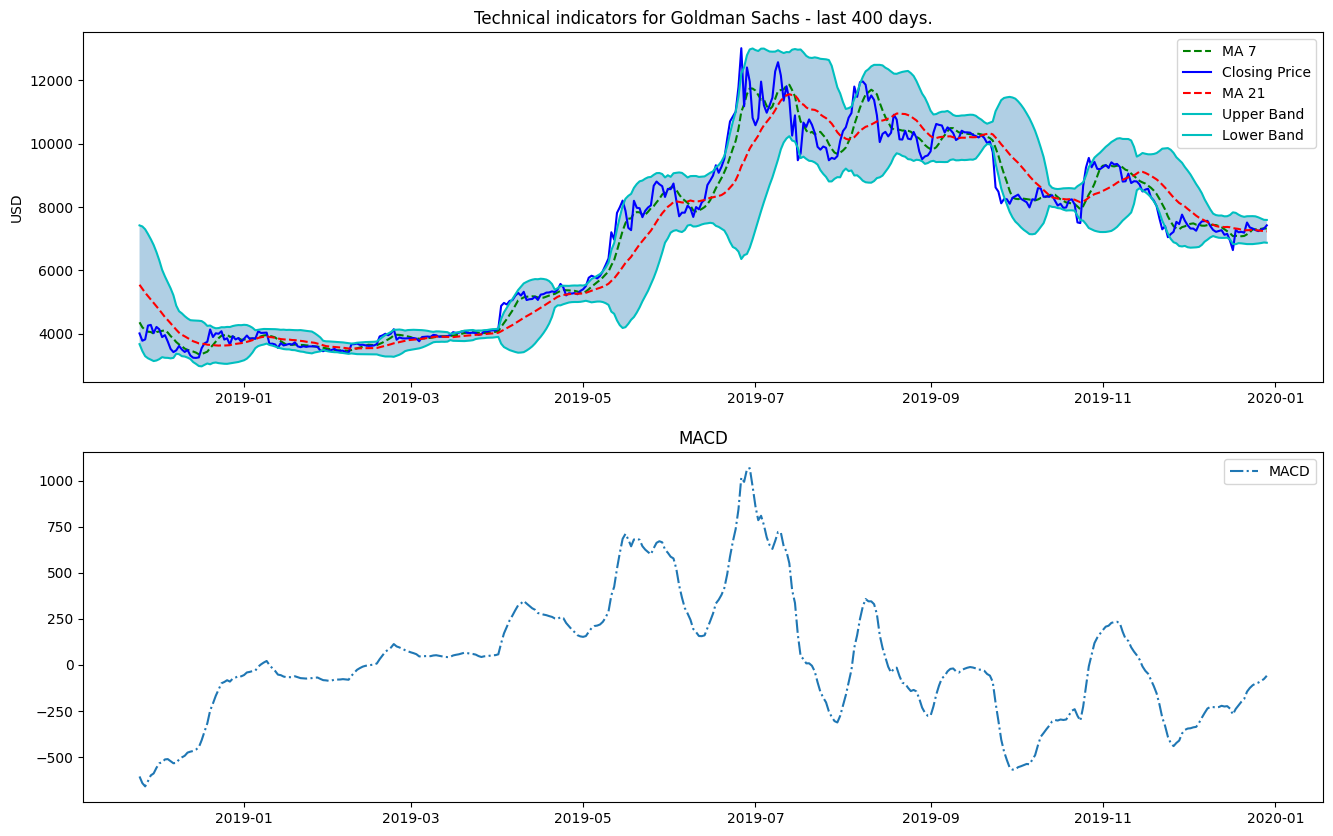

In [22]:
plot_technical_indicators(price_processed, 400)

In [23]:
price_processed.head()

Price,Close,High,Low,Open,Volume,change,change_label,ma7,ma21,26ema,12ema,MACD,20sd,upper_band,lower_band,ema
Ticker,BTC-USD,BTC-USD,BTC-USD,BTC-USD,BTC-USD,,,,,,,,,,,
Date,,,,,,,,,,,,,,,,
2015-01-21,226.897003,227.787994,211.212006,211.378006,29924600,0.028687,True,211.516142,252.197332,237.296354,225.220423,-12.075931,39.542978,331.283287,173.111376,221.826443
2015-01-22,233.406006,237.018997,226.434006,227.322006,33544600,-0.002258,False,214.882143,248.347666,236.943225,226.512490,-10.430735,36.472461,321.292588,175.402743,229.546152
2015-01-23,232.878998,234.845001,225.195999,233.516998,24621700,0.064274,True,218.422429,244.435617,236.580372,227.513418,-9.066953,35.544410,315.524437,173.346798,231.768049
2015-01-24,247.847000,248.210007,230.022003,232.699997,24782500,0.023688,True,225.363429,242.852998,237.571188,230.699476,-6.871711,35.208124,313.269246,172.436750,242.487350
2015-01-25,253.718002,255.074005,243.889999,247.352005,33582700,0.077862,True,231.560429,242.354093,238.971756,234.296011,-4.675745,34.492524,311.339142,173.369045,249.974451


# Format data for model

In [24]:
#now perhaps convert them to a list, and then tensor, to proceed to process the price data?
# drop columns we don't need and turn the rest into a NumPy array

x_input=price_processed.drop(['change','change_label'],axis=1).values

# scaler = MinMaxScaler()
# x_input= scaler.fit_transform(x_input)

# convert array to a regular Python list
x_input=x_input.tolist()


# extract the target column (change_label) as our labels
x_label=price_processed['change_label'].values
x_label=x_label.reshape(-1,).tolist()

#try to encode label
# encode labels to 1s and 0s (True → 1, False → 0)
x_label = [1 if x else 0 for x in x_label]


In [25]:
x_input[0]

[226.89700317382812,
 227.78799438476562,
 211.21200561523438,
 211.3780059814453,
 29924600.0,
 211.5161416190011,
 252.19733174641928,
 237.29635350176954,
 225.22042289269598,
 -12.075930609073566,
 39.542977728543526,
 331.28328720350635,
 173.1113762893322,
 221.8264434798479]

In [26]:
#roe relative price
# x_input = relative_price.drop(['change','change_label'],axis = 1).values


# # x_input= min_max_scaler.fit_transform(x_input)
# x_input=x_input.tolist()

# x_label=relative_price['change_label'].values
# x_label=x_label.reshape(-1,).tolist()
# #try to encode label
# x_label = [1 if x else 0 for x in x_label]

In [27]:
x_input[0],x_label[0]

([226.89700317382812,
  227.78799438476562,
  211.21200561523438,
  211.3780059814453,
  29924600.0,
  211.5161416190011,
  252.19733174641928,
  237.29635350176954,
  225.22042289269598,
  -12.075930609073566,
  39.542977728543526,
  331.28328720350635,
  173.1113762893322,
  221.8264434798479],
 1)

In [28]:
def process(data, window_size):
    output = []

   # slide a window over the data to create smaller overlapping chunks

    for i in range(window_size-1, len(data)):
        raw_data = data[i-window_size+1:i+1]
        output.append(raw_data)
    return output

window_size = 10
# create overlapping windows of size 10 from x_input

x_processed = process(x_input, 10)

# split 70% for training and 30% for evaluation
split = round(len(x_processed)*0.7)
x_train = x_processed[:split]
x_eval = x_processed[split:]

# convert to torch tensors for model input
x_train = torch.tensor(x_train, dtype=torch.float)
x_lab = torch.tensor(x_label[window_size-1:window_size-1+split],dtype=torch.float)


x_eval = torch.tensor(x_eval, dtype=torch.float)
x_lab_eval = torch.tensor(x_label[window_size-1+split:],dtype=torch.float)

# sanity checks — print shapes
print(x_train.size())
print(x_lab.size())
print(x_train[0])
print(x_label[0])
print(x_train.type())
print(x_lab.type())
print(x_eval.size())
print(x_lab_eval.size())

torch.Size([1256, 10, 14])
torch.Size([1256])
tensor([[ 2.2690e+02,  2.2779e+02,  2.1121e+02,  2.1138e+02,  2.9925e+07,
          2.1152e+02,  2.5220e+02,  2.3730e+02,  2.2522e+02, -1.2076e+01,
          3.9543e+01,  3.3128e+02,  1.7311e+02,  2.2183e+02],
        [ 2.3341e+02,  2.3702e+02,  2.2643e+02,  2.2732e+02,  3.3545e+07,
          2.1488e+02,  2.4835e+02,  2.3694e+02,  2.2651e+02, -1.0431e+01,
          3.6472e+01,  3.2129e+02,  1.7540e+02,  2.2955e+02],
        [ 2.3288e+02,  2.3485e+02,  2.2520e+02,  2.3352e+02,  2.4622e+07,
          2.1842e+02,  2.4444e+02,  2.3658e+02,  2.2751e+02, -9.0670e+00,
          3.5544e+01,  3.1552e+02,  1.7335e+02,  2.3177e+02],
        [ 2.4785e+02,  2.4821e+02,  2.3002e+02,  2.3270e+02,  2.4782e+07,
          2.2536e+02,  2.4285e+02,  2.3757e+02,  2.3070e+02, -6.8717e+00,
          3.5208e+01,  3.1327e+02,  1.7244e+02,  2.4249e+02],
        [ 2.5372e+02,  2.5507e+02,  2.4389e+02,  2.4735e+02,  3.3583e+07,
          2.3156e+02,  2.4235e+02,  2.38

# Prepare the Model

In [29]:
# assign train and eval data for convenience

train_data = x_train
train_label = x_lab

eval_data = x_eval
#print(test_data.size()) debugging purposes
eval_label = x_lab_eval
#print(test_label)

# batching  data
# (helps the model train in chunks instead of all at once)

batch_size = 64

# group the training data and labels together
train_data = TensorDataset(train_data, train_label)
train_loader = DataLoader(train_data, batch_size)
train_batches = [batch for batch in train_loader]

eval_data = TensorDataset(eval_data, eval_label)
eval_loader = DataLoader(eval_data, batch_size)
eval_batches = [batch for batch in eval_loader]

In [30]:
class OurModel(nn.Module):
    def __init__(self, input_size,  hidden_size, num_layers):
        super(OurModel, self).__init__()
        num_layers = num_layers

        # save key parameters
        self.input_size = input_size
        self.hidden_size = hidden_size

        # define the LSTM layer (sequence learner)

        self.lstm = nn.LSTM(self.input_size, self.hidden_size, num_layers, batch_first=True, bidirectional=False, dropout=0.5)

        # simple feed-forward layer to get final prediction
        self.ff = nn.Linear(self.hidden_size, 1)
        self.dropout = nn.Dropout()

        #need to change the loss function.
        #how data moves through the model
    def forward(self, input):

    # LSTM outputs hidden and cell states
        output, (hn, cn) = self.lstm(input)
        hn = self.dropout(hn[-1,:,:])        # take the last hidden state and apply dropout
        percent_change = self.ff(hn)
        return percent_change


In [31]:
#define model,

model = OurModel(14, 512, 2)

# for i in range(30):
#     for step, batch in enumerate(train_batches):
#         optimizer.step()
#         model.zero_grad()

#         data, label = tuple(t for t in batch)
#         model.train()
#         loss = model(data, label)
#         loss.backward()

#     model.eval()
#     output = evaluation(test_loader, model)
#     print('prediction:', output)
#     print(loss)

In [32]:
#define optimizer, loss function
params = model.parameters()
optimizer = optim.Adam(params)
criterion = nn.BCEWithLogitsLoss()

In [33]:
#Move model to device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
criterion = criterion.to(device)

print (device)

cuda


In [34]:
#check number of parameters.
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 3,183,105 trainable parameters


In [35]:
def binary_accuracy(preds, y):
    """
    Returns accuracy per batch, i.e. if you get 8/10 right, this returns 0.8, NOT 8
    """

    #round predictions to the closest integer
    rounded_preds = torch.round(torch.sigmoid(preds))
    correct = (rounded_preds == y).float() #convert into float for division
    acc = correct.sum() / len(correct)
    return acc

In [36]:
#here, let's try to define a function to get the confusion matrix stats



In [37]:
def train(model, train_batches, optimizer, criterion):

    epoch_loss = 0
    epoch_acc = 0

    # put model in training mode (enables dropout, gradient updates, etc.)
    model.train()

    for step, batch in enumerate(train_batches):

        optimizer.zero_grad() # clear gradients before each step

        data, label = tuple(t for t in batch)    # unpack batch (data + labels)

        # move tensors to GPU/CPU
        data = data.to(device)
        label = label.to(device)

        predictions = model(data).squeeze(1)

        # calculating loss between predicted and actual values
        loss = criterion(predictions, label)
        #loss = f1_loss(predictions, label)


        # measure accuracy on this batch
        acc = binary_accuracy(predictions, label)

        loss.backward()

        optimizer.step()

         # track total loss and accuracy for the epoch
        epoch_loss += loss.item()
        epoch_acc += acc.item()

    return epoch_loss / len(train_batches), epoch_acc / len(train_batches)

In [38]:
def evaluate(model, eval_batches, criterion):

    epoch_loss = 0
    epoch_acc = 0


    # switch model to evaluation mode (disables dropout, etc.)
    model.eval()


    # turn off gradient tracking (faster and saves memory)
    with torch.no_grad():

        for step, batch in enumerate(eval_batches):

            # unpack batch data and labels
            data, label = tuple(t for t in batch)
            data = data.to(device)
            label = label.to(device)

            predictions = model(data).squeeze(1)

            loss = criterion(predictions, label)

            acc = binary_accuracy(predictions, label)

            epoch_loss += loss.item()
            epoch_acc += acc.item()

    return epoch_loss / len(eval_batches), epoch_acc / len(eval_batches)

In [39]:
import time

def epoch_time(start_time, end_time):     # calculate how long one epoch took (in minutes + seconds)
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

N_EPOCHS = 10 # number of full passes through the dataset

best_valid_loss = float('inf')

for epoch in range(N_EPOCHS):

    start_time = time.time()

    # run one full pass of training and evaluation
    train_loss, train_acc = train(model, train_batches, optimizer, criterion)
    valid_loss, valid_acc = evaluate(model, eval_batches, criterion)

    end_time = time.time()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    # if valid_loss < best_valid_loss:
    #     best_valid_loss = valid_loss
    #     torch.save(model.state_dict(), 'tut2-model.pt')

    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')

Epoch: 01 | Epoch Time: 0m 0s
	Train Loss: 0.692 | Train Acc: 55.48%
	 Val. Loss: 0.694 |  Val. Acc: 51.36%
Epoch: 02 | Epoch Time: 0m 0s
	Train Loss: 0.698 | Train Acc: 52.45%
	 Val. Loss: 0.701 |  Val. Acc: 51.36%
Epoch: 03 | Epoch Time: 0m 0s
	Train Loss: 0.697 | Train Acc: 52.22%
	 Val. Loss: 0.721 |  Val. Acc: 51.36%
Epoch: 04 | Epoch Time: 0m 0s
	Train Loss: 0.691 | Train Acc: 55.84%
	 Val. Loss: 0.699 |  Val. Acc: 51.36%
Epoch: 05 | Epoch Time: 0m 0s
	Train Loss: 0.686 | Train Acc: 56.75%
	 Val. Loss: 0.704 |  Val. Acc: 51.36%
Epoch: 06 | Epoch Time: 0m 0s
	Train Loss: 0.688 | Train Acc: 55.97%
	 Val. Loss: 0.702 |  Val. Acc: 51.36%
Epoch: 07 | Epoch Time: 0m 0s
	Train Loss: 0.689 | Train Acc: 55.89%
	 Val. Loss: 0.701 |  Val. Acc: 51.36%
Epoch: 08 | Epoch Time: 0m 0s
	Train Loss: 0.688 | Train Acc: 56.83%
	 Val. Loss: 0.702 |  Val. Acc: 51.36%
Epoch: 09 | Epoch Time: 0m 0s
	Train Loss: 0.688 | Train Acc: 56.13%
	 Val. Loss: 0.700 |  Val. Acc: 51.36%
Epoch: 10 | Epoch Time: 0m 0

In [40]:
len(train_batches)

20

In [41]:
# initialize empty tensors to store predictions and true labels

predlist=torch.zeros(0,dtype=torch.long, device='cpu')
lbllist=torch.zeros(0,dtype=torch.long, device='cpu')

with torch.no_grad():
  for step, batch in enumerate(eval_batches):
    data, label = (t for t in batch)
    data = data.to(device)
    label = label.to(device)
    predictions = model(data).squeeze(1)

    # apply sigmoid to convert logits → probabilities (0–1)
    predictions = torch.sigmoid(predictions)
    predictions = torch.round(predictions)

    # store predictions and labels for later comparison

    predlist=torch.cat([predlist,predictions.view(-1).cpu()])
    lbllist=torch.cat([lbllist,label.view(-1).cpu()])


In [42]:
conf_mat=confusion_matrix(lbllist.numpy(), predlist.numpy())
print(conf_mat)


[[  0 261]
 [  0 278]]


In [ ]:
predlist

tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 

In [43]:
lbllist

tensor([0., 1., 0., 1., 1., 1., 1., 1., 1., 1., 0., 1., 0., 1., 1., 0., 0., 1.,
        1., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 1., 1., 0., 0.,
        1., 1., 1., 0., 1., 0., 1., 0., 1., 1., 1., 0., 1., 1., 0., 0., 1., 1.,
        1., 0., 1., 0., 0., 0., 0., 1., 1., 0., 1., 1., 0., 1., 0., 0., 1., 1.,
        1., 1., 0., 0., 0., 0., 1., 1., 0., 0., 1., 0., 0., 0., 1., 1., 0., 1.,
        1., 0., 0., 0., 1., 1., 1., 1., 0., 0., 0., 0., 1., 0., 1., 0., 1., 0.,
        0., 1., 1., 0., 1., 0., 1., 1., 0., 1., 1., 1., 1., 0., 0., 1., 1., 0.,
        0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 1., 0., 1., 1., 1., 0.,
        1., 0., 0., 1., 0., 0., 0., 1., 1., 0., 0., 1., 0., 0., 0., 1., 1., 1.,
        1., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 1., 0., 1., 0.,
        1., 0., 1., 1., 0., 1., 0., 0., 1., 0., 1., 1., 0., 1., 0., 0., 1., 0.,
        1., 0., 1., 0., 0., 0., 1., 0., 1., 1., 0., 0., 1., 0., 0., 1., 1., 1.,
        0., 1., 0., 0., 1., 1., 1., 1., 

# Trying out New Loss function for F1

In [44]:
class OurModel2(nn.Module):
    def __init__(self, input_size,  hidden_size, num_layers):
        super(OurModel2, self).__init__()
        num_layers = num_layers
        self.input_size = input_size         # save model parameters
        self.hidden_size = hidden_size
        self.lstm = nn.LSTM(self.input_size, self.hidden_size, num_layers, batch_first=True, bidirectional=False, dropout=0.5)
        self.ff = nn.Linear(self.hidden_size, 256)      # LSTM layer for sequence learning
        self.ff2 = nn.Linear(256,2)     # second feed-forward layer → final output (2 classes)
        self.dropout = nn.Dropout()

        #need to change the loss function.
    def forward(self, input):    # LSTM produces output + hidden + cell states
        output, (hn, cn) = self.lstm(input)
        hn = self.dropout(hn[-1,:,:])

        # pass through two fully-connected layers

        percent_change = self.ff(hn)
        percent_change2 = self.ff2(percent_change)
        return percent_change2

# create an instance of the model with given dimensions

model2 = OurModel2(14,512,2)

In [45]:
#define optimizer, loss function
params2 = model2.parameters()
optimizer2 = optim.Adam(params2)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model2 = model2.to(device)

print (device)

cuda


In [46]:
class F1_Loss(nn.Module):
    '''Calculate F1 score. Can work with gpu tensors

    The original implmentation is written by Michal Haltuf on Kaggle.

    Returns
    -------
    torch.Tensor
        `ndim` == 1. epsilon <= val <= 1

    Reference
    ---------
    - https://www.kaggle.com/rejpalcz/best-loss-function-for-f1-score-metric
    - https://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html#sklearn.metrics.f1_score
    - https://discuss.pytorch.org/t/calculating-precision-recall-and-f1-score-in-case-of-multi-label-classification/28265/6
    - http://www.ryanzhang.info/python/writing-your-own-loss-function-module-for-pytorch/
    '''
    def __init__(self, epsilon=1e-7):
        super().__init__()
        self.epsilon = epsilon  # tiny constant to prevent division by zero

    def forward(self, y_pred, y_true,):    # make sure dimensions match expectations
        assert y_pred.ndim == 2
        assert y_true.ndim == 1
        y_true = F.one_hot(y_true, 2).to(torch.float32)
        y_pred = F.softmax(y_pred, dim=1)      # turn raw model outputs (logits) into probabilities


        # compute TP, TN, FP, FN across each class
        tp = (y_true * y_pred).sum(dim=0).to(torch.float32)
        tn = ((1 - y_true) * (1 - y_pred)).sum(dim=0).to(torch.float32)
        fp = ((1 - y_true) * y_pred).sum(dim=0).to(torch.float32)
        fn = (y_true * (1 - y_pred)).sum(dim=0).to(torch.float32)

        precision = tp / (tp + fp + self.epsilon)
        recall = tp / (tp + fn + self.epsilon)

        f1 = 2* (precision*recall) / (precision + recall + self.epsilon)
        f1 = f1.clamp(min=self.epsilon, max=1-self.epsilon)
        return 1 - f1.mean()

f1_loss = F1_Loss().cuda()

In [47]:
def accuracy(preds, y):
    """
    Returns accuracy per batch, i.e. if you get 8/10 right, this returns 0.8, NOT 8
    """

    #round predictions to the closest integer
    prediciton = F.softmax(preds, dim =1)
    _, pred = torch.max(prediciton, 1)
    correct = (pred == y).float() #convert into float for division
    acc = correct.sum() / len(correct)
    return acc

In [48]:
def train(model, train_batches, optimizer, criterion):

    epoch_list=[]
    epoch_loss = 0
    epoch_acc = 0

    model.train()

    for step, batch in enumerate(train_batches):

        optimizer.zero_grad()  # clear old grads

        data, label = tuple(t for t in batch)

        data = data.to(device)
        label = label.to(device)

        predictions = model(data)

        # use custom F1 loss (labels must be int64 for one_hot)
        loss = f1_loss(predictions, label.to(torch.int64))

        acc = accuracy(predictions, label)

        loss.backward()

        optimizer.step()

        # track
        epoch_list.append(loss.item())
        epoch_loss += loss.item()
        epoch_acc += acc.item()

    return epoch_loss / len(train_batches), epoch_acc / len(train_batches), epoch_list

In [49]:
def evaluate(model, eval_batches, criterion):

    epoch_loss = 0
    epoch_acc = 0

    model.eval()

    with torch.no_grad():

        # loop through all validation/evaluation batches
        for step, batch in enumerate(eval_batches):

            data, label = tuple(t for t in batch)
            data = data.to(device)
            label = label.to(device)

            predictions = model(data)

            loss = f1_loss(predictions, label.to(torch.int64))

            acc = accuracy(predictions, label)

            epoch_loss += loss.item()
            epoch_acc += acc.item()

    return epoch_loss / len(eval_batches), epoch_acc / len(eval_batches)

In [50]:
import time

def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

N_EPOCHS = 10

best_valid_loss = float('inf')

for epoch in range(N_EPOCHS):

    start_time = time.time()

    train_loss, train_acc, train_loss_list = train(model2, train_batches, optimizer2, criterion)
    valid_loss, valid_acc = evaluate(model2, eval_batches, criterion)

    end_time = time.time()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    # if valid_loss < best_valid_loss:
    #     best_valid_loss = valid_loss
    #     torch.save(model.state_dict(), 'tut2-model.pt')

    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\t Train. Loss: {train_loss:.3f} |  Train. Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')

Epoch: 01 | Epoch Time: 0m 0s
	 Train. Loss: 0.506 |  Train. Acc: 52.81%
	 Val. Loss: 0.506 |  Val. Acc: 48.64%
Epoch: 02 | Epoch Time: 0m 0s
	 Train. Loss: 0.507 |  Train. Acc: 53.48%
	 Val. Loss: 0.503 |  Val. Acc: 48.64%
Epoch: 03 | Epoch Time: 0m 0s
	 Train. Loss: 0.502 |  Train. Acc: 52.34%
	 Val. Loss: 0.502 |  Val. Acc: 51.36%
Epoch: 04 | Epoch Time: 0m 0s
	 Train. Loss: 0.500 |  Train. Acc: 53.19%
	 Val. Loss: 0.502 |  Val. Acc: 51.36%
Epoch: 05 | Epoch Time: 0m 0s
	 Train. Loss: 0.508 |  Train. Acc: 51.48%
	 Val. Loss: 0.505 |  Val. Acc: 48.64%
Epoch: 06 | Epoch Time: 0m 0s
	 Train. Loss: 0.508 |  Train. Acc: 52.27%
	 Val. Loss: 0.502 |  Val. Acc: 48.64%
Epoch: 07 | Epoch Time: 0m 0s
	 Train. Loss: 0.515 |  Train. Acc: 51.17%
	 Val. Loss: 0.503 |  Val. Acc: 51.36%
Epoch: 08 | Epoch Time: 0m 0s
	 Train. Loss: 0.508 |  Train. Acc: 52.67%
	 Val. Loss: 0.508 |  Val. Acc: 51.36%
Epoch: 09 | Epoch Time: 0m 0s
	 Train. Loss: 0.509 |  Train. Acc: 51.47%
	 Val. Loss: 0.511 |  Val. Acc:

In [51]:
train_loss_list

[0.4901319742202759,
 0.517310380935669,
 0.5020704865455627,
 0.5071017742156982,
 0.48143965005874634,
 0.49793124198913574,
 0.4819549322128296,
 0.5207098126411438,
 0.4844570755958557,
 0.49103158712387085,
 0.4940582513809204,
 0.48712772130966187,
 0.49156737327575684,
 0.4993631839752197,
 0.49887973070144653,
 0.5037999153137207,
 0.506164014339447,
 0.49551498889923096,
 0.5268250703811646,
 0.49425262212753296]

In [52]:
model2.parameters()

<generator object Module.parameters at 0x7b44174927a0>

In [53]:
print (model2)

OurModel2(
  (lstm): LSTM(14, 512, num_layers=2, batch_first=True, dropout=0.5)
  (ff): Linear(in_features=512, out_features=256, bias=True)
  (ff2): Linear(in_features=256, out_features=2, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)


In [54]:
list(model2.parameters())

[Parameter containing:
 tensor([[-0.0419,  0.0165,  0.0151,  ..., -0.0324, -0.0236, -0.0199],
         [ 0.0063,  0.0091,  0.0218,  ...,  0.0066,  0.0353, -0.0252],
         [-0.0364,  0.0003,  0.0348,  ..., -0.0295,  0.0237, -0.0405],
         ...,
         [ 0.0179,  0.0292,  0.0294,  ...,  0.0043, -0.0408, -0.0222],
         [-0.0267,  0.0055,  0.0050,  ..., -0.0307, -0.0255,  0.0404],
         [ 0.0202,  0.0125,  0.0205,  ...,  0.0009, -0.0403,  0.0205]],
        device='cuda:0', requires_grad=True),
 Parameter containing:
 tensor([[-0.0067,  0.0264,  0.0022,  ..., -0.0105,  0.0340, -0.0136],
         [-0.0367, -0.0199, -0.0050,  ..., -0.0375,  0.0301, -0.0210],
         [ 0.0396,  0.0402, -0.0320,  ...,  0.0103, -0.0201, -0.0194],
         ...,
         [-0.0118, -0.0062,  0.0245,  ...,  0.0034,  0.0221,  0.0320],
         [-0.0083, -0.0405,  0.0109,  ..., -0.0098, -0.0033, -0.0350],
         [-0.0213,  0.0237,  0.0407,  ...,  0.0018,  0.0066,  0.0076]],
        device='cuda:0', r

In [55]:
#Check if weights are updated.

old_state_dict = {}
for key in model2.state_dict():
  old_state_dict[key] = model2.state_dict()[key].clone()

# Your training procedure
import time

def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

N_EPOCHS = 10

best_valid_loss = float('inf')

for epoch in range(N_EPOCHS):

    start_time = time.time()

    train_loss, train_acc, train_loss_list = train(model2, train_batches, optimizer2, criterion)
    valid_loss, valid_acc = evaluate(model2, eval_batches, criterion)

    end_time = time.time()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    # if valid_loss < best_valid_loss:
    #     best_valid_loss = valid_loss
    #     torch.save(model.state_dict(), 'tut2-model.pt')

    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\t Train. Loss: {train_loss:.3f} |  Train. Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')
# Save new params
new_state_dict = {}
for key in model2.state_dict():
    new_state_dict[key] = model2.state_dict()[key].clone()

# Compare params
for key in old_state_dict:
    if not (old_state_dict[key] == new_state_dict[key]).all():
        print('Diff in {}'.format(key))

Epoch: 01 | Epoch Time: 0m 0s
	 Train. Loss: 0.505 |  Train. Acc: 51.53%
	 Val. Loss: 0.507 |  Val. Acc: 51.36%
Epoch: 02 | Epoch Time: 0m 0s
	 Train. Loss: 0.506 |  Train. Acc: 51.62%
	 Val. Loss: 0.508 |  Val. Acc: 51.36%
Epoch: 03 | Epoch Time: 0m 0s
	 Train. Loss: 0.508 |  Train. Acc: 51.14%
	 Val. Loss: 0.506 |  Val. Acc: 51.36%
Epoch: 04 | Epoch Time: 0m 0s
	 Train. Loss: 0.500 |  Train. Acc: 53.27%
	 Val. Loss: 0.506 |  Val. Acc: 51.36%
Epoch: 05 | Epoch Time: 0m 0s
	 Train. Loss: 0.497 |  Train. Acc: 54.63%
	 Val. Loss: 0.506 |  Val. Acc: 51.36%
Epoch: 06 | Epoch Time: 0m 0s
	 Train. Loss: 0.504 |  Train. Acc: 51.84%
	 Val. Loss: 0.512 |  Val. Acc: 51.36%
Epoch: 07 | Epoch Time: 0m 0s
	 Train. Loss: 0.509 |  Train. Acc: 51.77%
	 Val. Loss: 0.513 |  Val. Acc: 51.36%
Epoch: 08 | Epoch Time: 0m 0s
	 Train. Loss: 0.500 |  Train. Acc: 53.00%
	 Val. Loss: 0.509 |  Val. Acc: 51.36%
Epoch: 09 | Epoch Time: 0m 0s
	 Train. Loss: 0.495 |  Train. Acc: 52.95%
	 Val. Loss: 0.505 |  Val. Acc:

In [ ]:
# POST-RUN A — standardize `price` to have Date, Open, High, Low, Close, Adj Close, Volume, date
import pandas as pd, numpy as np

print("Before:", list(price.columns))
p = price.copy()

# Flatten MultiIndex columns if any
# This block converts them into simple single-level column names by joining with underscores.
if isinstance(p.columns, pd.MultiIndex):
    p.columns = ['_'.join([str(x) for x in col if str(x)]) for col in p.columns]

# This section ensures there’s always a consistent 'Date' column.
if 'Date' not in p.columns:
    p = p.reset_index()
    for cand in ['Date','Datetime','date','Index','Timestamp']:
        if cand in p.columns:
          # rename whichever version of date we find to standard 'Date'

            p = p.rename(columns={cand:'Date'})
            break
p['Date'] = pd.to_datetime(p['Date'])

# This helper function tries to find a match for each OHLCV component, ignoring case and excluding “adj” variants.
def pick(token, exclude=('adj',)):
    cands = [c for c in p.columns if token in c.lower() and not any(ex in c.lower() for ex in exclude)]
    return cands[0] if cands else None

open_col  = pick('open')
high_col  = pick('high')
low_col   = pick('low')
# prefer exact 'close'
close_col = ( [c for c in p.columns if c.lower()=='close'] or
              [c for c in p.columns if c.lower().endswith('_close')] or
              [c for c in p.columns if 'close' in c.lower() and 'adj' not in c.lower()] )
close_col = close_col[0] if close_col else None
vol_col   = pick('volume')

# If any missing, itll reload clean OHLCV for the visible date span (yfinance)
# This ensures the final DataFrame always has full standard structure.

missing = [n for n,v in [('Open',open_col),('High',high_col),('Low',low_col),('Close',close_col),('Volume',vol_col)] if v is None]
if missing:
    import yfinance as yf
    #date range
    start = str(p['Date'].min().date()) if 'Date' in p.columns else '2018-01-01'
    end   = str(p['Date'].max().date()) if 'Date' in p.columns else None
    y = yf.download("BTC-USD", start=start, end=end, auto_adjust=False, progress=False, threads=False)
    y = y.reset_index()[['Date','Open','High','Low','Close','Adj Close','Volume']]
    y['date'] = y['Date'].dt.strftime('%Y-%m-%d')
    p = y
    open_col,high_col,low_col,close_col,vol_col = 'Open','High','Low','Close','Volume'

# Standardizing names and keys
p = p.rename(columns={
    open_col:'Open', high_col:'High', low_col:'Low', close_col:'Close', vol_col:'Volume'
}) if missing else p
if 'Adj Close' not in p.columns:
    p['Adj Close'] = p['Close']
if 'date' not in p.columns:
    p['date'] = p['Date'].dt.strftime('%Y-%m-%d')

price = p[['Date','Open','High','Low','Close','Adj Close','Volume','date']].sort_values('Date').reset_index(drop=True)
print("After:", list(price.columns))


Before: ['Date', 'date']
After: [('Date', ''), ('Open', 'BTC-USD'), ('High', 'BTC-USD'), ('Low', 'BTC-USD'), ('Close', 'BTC-USD'), ('Adj Close', 'BTC-USD'), ('Volume', 'BTC-USD'), ('date', '')]


In [ ]:
# POST-RUN B — anomalies + labels

# This section engineers new columns for volatility-based anomaly detection and daily returns

r = price['Close'].pct_change()
price['ret_1d']     = r
price['log_ret_1d'] = np.log(price['Close']).diff()


# Compute rolling volatility (std) using a 21-day lookback window.


sigma = r.rolling(21, min_periods=10).std()

# "jump" indicates days with unusually large moves
price['jump'] = (r.abs() > 2.5*sigma).astype(int)

# sum gives a short-term measure of recent turbulence.
price['jump_count_7d'] = price['jump'].rolling(7, min_periods=1).sum()

q = r.abs().quantile(0.975)
price['anom_score'] = (r.abs() / sigma.replace(0, np.nan)).fillna(0.0)
price['anom_flag']  = (r.abs() >= q).astype(int)

# These can later serve as prediction targets in a classification model
for k in (1, 4, 7):
    price[f'ret_fwd_{k}d']      = price['Close'].pct_change(k).shift(-k)
    price[f'move_gt_{k}d_2pct'] = (price[f'ret_fwd_{k}d'].abs() > 0.02).astype(int)


Saved /content/price_with_anomalies.(parquet|csv)


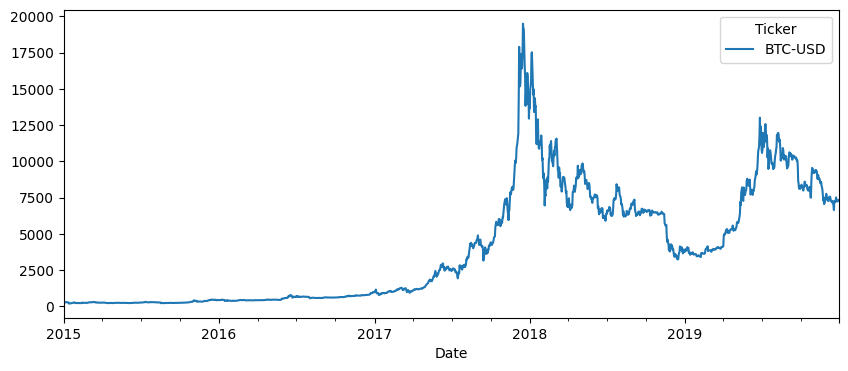

In [ ]:
# POST-RUN C — persist + optional visual
price.to_parquet('/content/price_with_anomalies.parquet', index=False)
price.to_csv('/content/price_with_anomalies.csv', index=False)
print('Saved /content/price_with_anomalies.(parquet|csv)')

try:
    import matplotlib.pyplot as plt
    ax = price.plot(x='Date', y='Close', figsize=(10,4))
    ax.scatter(price.loc[price['anom_flag']==1,'Date'],
               price.loc[price['anom_flag']==1,'Close'], s=12)
    ax.set_title('BTC Close with anomaly flags')
    plt.show()
except Exception as _:
    pass


In [ ]:
# what new columns we added + basic shape
cols_new = ['ret_1d','log_ret_1d','jump','jump_count_7d','anom_score','anom_flag',
            'ret_fwd_1d','ret_fwd_4d','ret_fwd_7d','move_gt_1d_2pct','move_gt_4d_2pct','move_gt_7d_2pct']
print("rows:", len(price), "| dates:", price['Date'].min().date(), "→", price['Date'].max().date())
print(sorted([c for c in cols_new if c in price.columns]))
price[ ['Date','Close'] + [c for c in cols_new if c in price.columns] ].head(10)


rows: 1823 | dates: 2015-01-01 → 2019-12-28
['anom_flag', 'anom_score', 'jump', 'jump_count_7d', 'log_ret_1d', 'move_gt_1d_2pct', 'move_gt_4d_2pct', 'move_gt_7d_2pct', 'ret_1d', 'ret_fwd_1d', 'ret_fwd_4d', 'ret_fwd_7d']


Price,Date,Close,ret_1d,log_ret_1d,jump,jump_count_7d,anom_score,anom_flag,ret_fwd_1d,ret_fwd_4d,ret_fwd_7d,move_gt_1d_2pct,move_gt_4d_2pct,move_gt_7d_2pct
Ticker,,BTC-USD,,,,,,,,,,,,
0,2015-01-01,314.248993,NaN,NaN,0,0.0,0.0,0,0.002492,-0.126572,-0.098330,0,1,1
1,2015-01-02,315.032013,0.002492,0.002489,0,0.0,0.0,0,-0.107767,-0.091556,-0.078164,1,1,1
2,2015-01-03,281.082001,-0.107767,-0.114028,0,0.0,0.0,1,-0.060079,0.047157,-0.022364,1,1,1
3,2015-01-04,264.195007,-0.060079,-0.061959,0,0.0,0.0,0,0.038907,0.072499,0.005545,1,1,0
4,2015-01-05,274.473999,0.038907,0.038169,0,0.0,0.0,0,0.042682,0.058053,-0.024330,1,1,1
5,2015-01-06,286.188995,0.042682,0.041796,0,0.0,0.0,0,0.028471,-0.039809,-0.210798,1,1,1
6,2015-01-07,294.337006,0.028471,0.028073,0,0.0,0.0,0,-0.037331,-0.097429,-0.394901,1,1,1
7,2015-01-08,283.348999,-0.037331,-0.038046,0,0.0,0.0,0,0.024913,-0.054890,-0.259415,1,1,1
8,2015-01-09,290.407990,0.024913,0.024607,0,0.0,0.0,0,-0.053759,-0.222263,-0.283432,1,1,1


In [ ]:
#Top shocks table (ranked by anomaly score)

topN = price.nlargest(15, 'anom_score')[['Date','Close','ret_1d','anom_score','jump','jump_count_7d']]
topN.style.format({'Close':'{:.2f}','ret_1d':'{:+.3%}','anom_score':'{:.2f}'})


Price,Date,Close,ret_1d,anom_score,jump,jump_count_7d
Ticker,,BTC-USD,,,,
1552,2019-04-02 00:00:00,4879.877930,0.173560,4.513523,1,1.000000
1413,2018-11-14 00:00:00,5738.350098,-0.097671,4.351231,1,1.000000
229,2015-08-18 00:00:00,211.078995,-0.181788,4.320409,1,1.000000
1727,2019-09-24 00:00:00,8620.566406,-0.113960,4.220317,1,1.000000
1070,2017-12-06 00:00:00,14291.500000,0.199283,4.146192,1,1.000000
513,2016-05-28 00:00:00,530.039978,0.119494,4.057894,1,2.000000
1591,2019-05-11 00:00:00,7204.771484,0.129478,3.855366,1,1.000000
579,2016-08-02 00:00:00,547.465027,-0.096998,3.821953,1,2.000000
1071,2017-12-07 00:00:00,17899.699219,0.252472,3.745118,1,2.000000


In [ ]:
# do days flagged as "anomalies" really tend to have bigger price swings?

# This tells us how common large moves are in general
base_rate = price['move_gt_1d_2pct'].mean()
coverage  = price.loc[price['anom_flag']==1,'move_gt_1d_2pct'].mean()  # In probability terms, P(big move | anomaly today)
trigger_rate = price['anom_flag'].mean()                               # how often we flag
print(f"Base big-move rate: {base_rate:.3%}")
print(f"Big-move rate on anomaly days: {coverage:.3%}")
print(f"Anomaly trigger rate: {trigger_rate:.3%}")


Base big-move rate: 40.538%
Big-move rate on anomaly days: 71.739%
Anomaly trigger rate: 2.523%


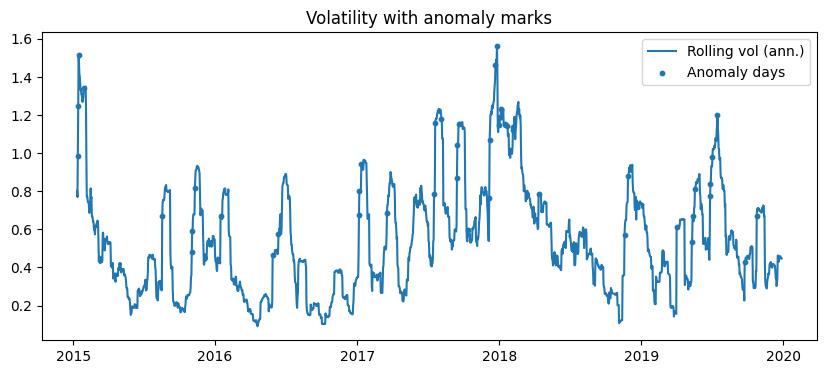

In [ ]:
# Volatility + anomalies plot

import matplotlib.pyplot as plt

# Multiplying by sqrt(252) scales daily volatility to an annualized measure
sigma = price['ret_1d'].rolling(21, min_periods=10).std()*np.sqrt(252)  # annualized

# Creating a new figure and axis for plotting
fig, ax = plt.subplots(figsize=(10,4))
ax.plot(price['Date'], sigma, label='Rolling vol (ann.)')
ax.scatter(price.loc[price['anom_flag']==1,'Date'],
           sigma.loc[price['anom_flag']==1], s=10, label='Anomaly days')
ax.set_title('Volatility with anomaly marks'); ax.legend(); plt.show()


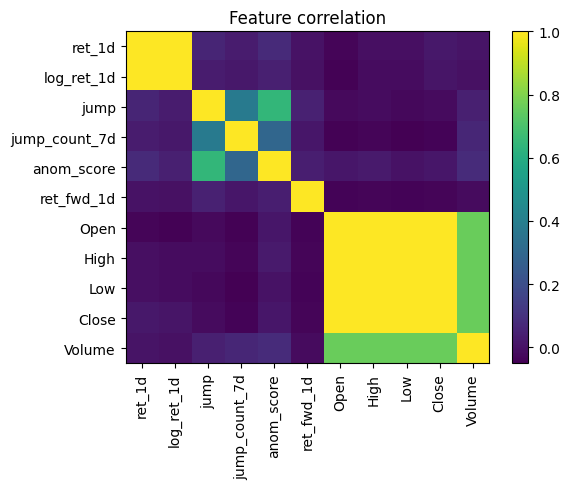

In [ ]:
#Feature correlation heatmap (quick sanity)
# trying to visualize how the  features relate to each other

# Only the columns that actually exist in `price`
feats = [c for c in ['ret_1d','log_ret_1d','jump','jump_count_7d','anom_score',
                     'ret_fwd_1d','Open','High','Low','Close','Volume'] if c in price.columns]

#corr matrix
corr = price[feats].corr()
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(6,5))
im = ax.imshow(corr.values, aspect='auto')
ax.set_xticks(range(len(feats))); ax.set_yticks(range(len(feats)))
ax.set_xticklabels(feats, rotation=90); ax.set_yticklabels(feats)
fig.colorbar(im, ax=ax); ax.set_title('Feature correlation'); plt.tight_layout(); plt.show()


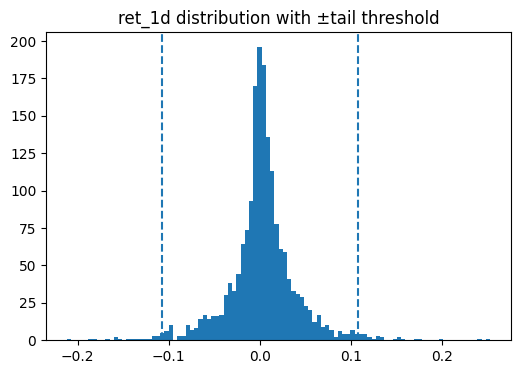

In [ ]:
# Return distribution with tail cutoff

# Visualize (top 2.5% tails)

q = price['ret_1d'].abs().quantile(0.975)
fig, ax = plt.subplots(figsize=(6,4))
ax.hist(price['ret_1d'].dropna(), bins=100)
ax.axvline(q,  ls='--'); ax.axvline(-q, ls='--') # positive and neg tail lines
ax.set_title('ret_1d distribution with ±tail threshold'); plt.show()
